# MA3001B




## Portafolio del gus

We will build an ARIMA model for the famous "Daily female births in California in 1959".

In [38]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller,kpss # to do ADF test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA # to do predictions
from sklearn.model_selection import train_test_split
import requests, io #type: ignore
import pmdarima as pm

data = pd.read_csv("data.csv")

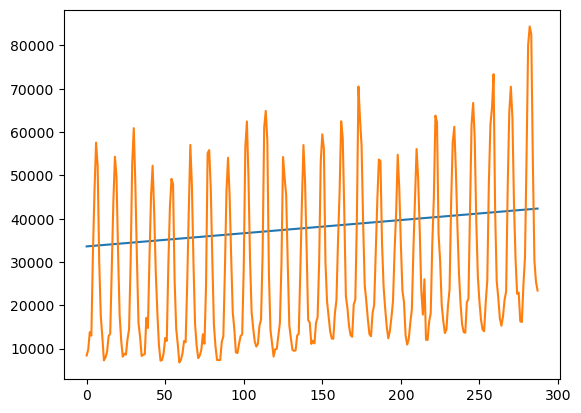

In [39]:
plt.plot(data)
plt.show()


We perform the Q-test to check whether there is autocorrelation in the series to use an ARIMA model.

In [40]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(data["TouristNumber"].values)


,lb_stat,lb_pvalue
1,192.180851,1.062459e-43
2,243.347584,1.437949e-53
3,243.435422,1.720184e-52
4,282.414013,6.721979e-60
5,374.506023,9.237014e-79
6,488.136851,3.019824e-102
7,576.349319,3.010715e-120
8,611.975920,6.227934e-127
9,612.088155,5.325059e-126
10,656.970266,1.076157e-134


Since the p-value is very small we conclude that there is autocorrelation in the series.
We can observe from the plot that there is a light trend in the series, so we use differencing to remove the trend.

In [41]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def test_stationarity(timeseries):

    #Determining rolling statistics
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    #plotting rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    st = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling  Mean & Standard Deviation')
    plt.show()

    #Dickey_Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

    #kpss test:
    print('Results of kpss Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

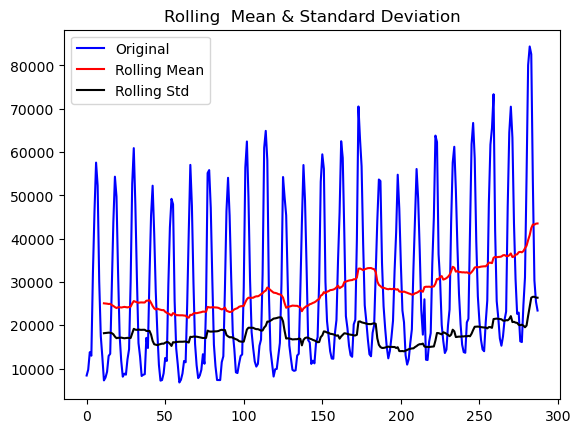

Results of Dickey-Fuller Test:
Test Statistic                   1.247470
p-value                          0.996298
#Lags Used                      13.000000
Number of Observations Used    274.000000
Critical Value (1%)             -3.454444
Critical Value (5%)             -2.872147
Critical Value (10%)            -2.572422
dtype: float64
Results of kpss Test:
Test Statistic           0.976983
p-value                  0.010000
#Lags Used               7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\Users\gusal\miniconda3\envs\Ambiente-Conda\lib\site-packages\statsmodels\tsa\stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


In [42]:
test_stationarity(pd.Series(data["TouristNumber"].values))


We apply the diff:

In [43]:
from statsmodels.tsa.statespace.tools import diff
differentiated = diff(data["TouristNumber"],k_diff=1)


Check for stationarity

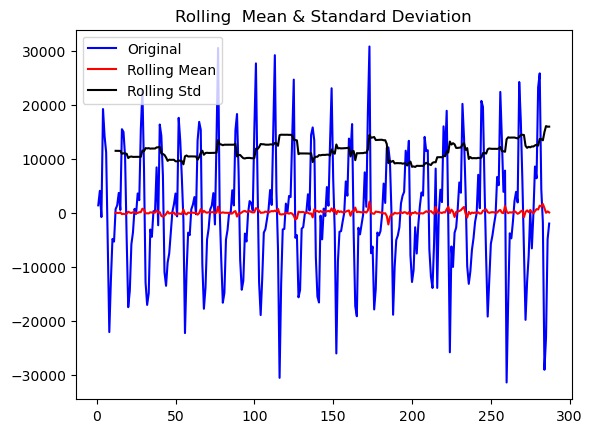

Results of Dickey-Fuller Test:
Test Statistic                -8.170180e+00
p-value                        8.665018e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.740000e+02
Critical Value (1%)           -3.454444e+00
Critical Value (5%)           -2.872147e+00
Critical Value (10%)          -2.572422e+00
dtype: float64
Results of kpss Test:
Test Statistic           0.008515
p-value                  0.100000
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\Users\gusal\miniconda3\envs\Ambiente-Conda\lib\site-packages\statsmodels\tsa\stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [44]:
test_stationarity(differentiated)


Apply the Q-test again

In [45]:
acorr_ljungbox(differentiated)


,lb_stat,lb_pvalue
1,90.715130,1.659196e-21
2,94.625831,2.833100e-21
3,111.168607,6.149364e-24
4,157.186406,5.865184e-33
5,193.851696,5.866321e-40
6,232.132248,2.685264e-47
7,266.990889,6.666578e-54
8,305.269367,3.111511e-61
9,320.115094,1.402019e-63
10,324.895704,8.379118e-64


Now, let's check the ACF:

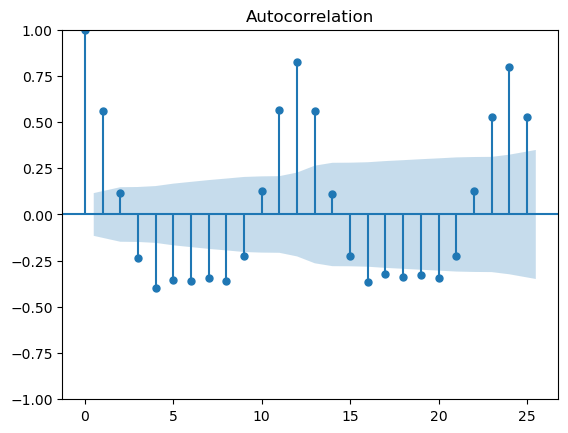

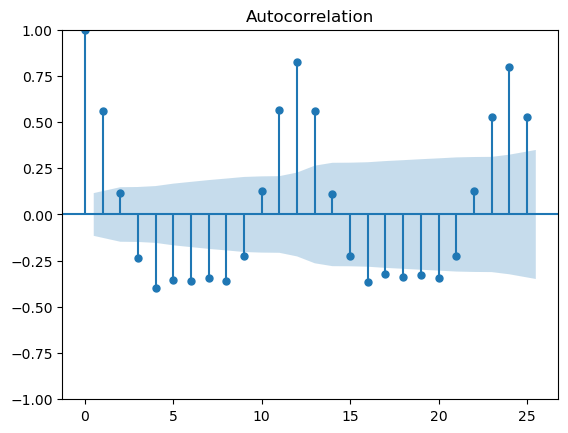

In [46]:
plot_acf(differentiated)


Let's check the PACF

c:\Users\gusal\miniconda3\envs\Ambiente-Conda\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


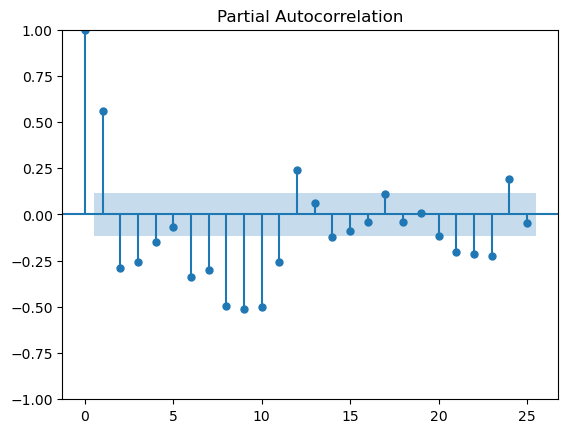

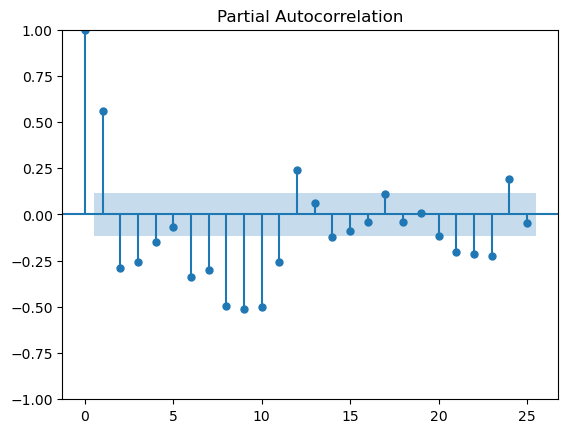

In [47]:
plot_pacf(differentiated)


First model: (once you set d=1, you apply the model to the original series)

In [48]:
import statsmodels.api as sm
p = 1
d = 1
q = 1
model = sm.tsa.ARIMA(data["TouristNumber"], order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:          TouristNumber   No. Observations:                  288
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3022.293
Date:                Thu, 24 Oct 2024   AIC                           6050.586
Time:                        22:18:38   BIC                           6061.564
Sample:                             0   HQIC                          6054.986
                                - 288                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3866      0.098      3.951      0.000       0.195       0.578
ma.L1          0.2793      0.106      2.625      0.009       0.071       0.488
sigma2      8.388e+07   5.08e-11   1.65e+18      0.0

Let's check the residuals:

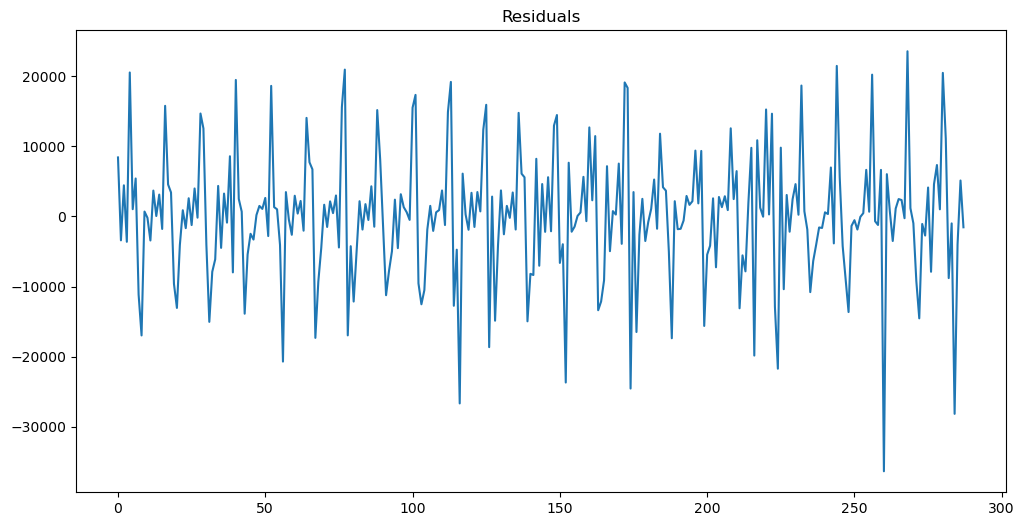

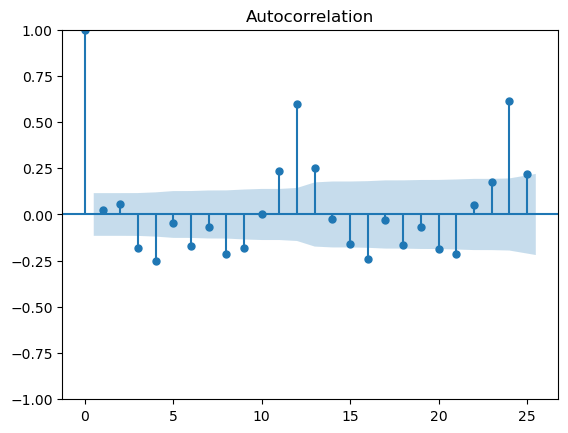

In [49]:
# Plot the residuals
plt.figure(figsize=(12, 6))
plt.plot(model_fit.resid)
plt.title('Residuals')
plt.show()

# Plot the ACF of the residuals
plot_acf(model_fit.resid)
plt.show()

Q-test on residuals:

In [50]:
acorr_ljungbox(model_fit.resid)

,lb_stat,lb_pvalue
1,0.161341,6.879253e-01
2,1.055314,5.899857e-01
3,10.930234,1.210917e-02
4,29.660929,5.737262e-06
5,30.341079,1.263513e-05
6,39.040980,7.026425e-07
7,40.319139,1.093563e-06
8,54.212392,6.278686e-09
9,64.061107,2.196140e-10
10,64.069450,6.104465e-10


Let's calculate SSE:

In [51]:
# Calculate the SSE of the residuals
sse = np.sum(np.square(model_fit.resid))
print(f"SSE of the residuals: {sse}")

SSE of the residuals: 23624437984.13773


## AutoARIMA

It is possible to use an automatic procedure to fine the best model. The procedure tests the series to find the order of differencing and fits the series with several models.




In [52]:
# Fit auto_arima to the data
auto_model = pm.auto_arima(data['TouristNumber'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

# Print the summary of the best model
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6169.098, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5992.445, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6167.106, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6067.022, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5719.516, Time=0.57 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=5679.177, Time=1.06 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=5646.019, Time=1.05 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=5752.970, Time=1.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=inf, T

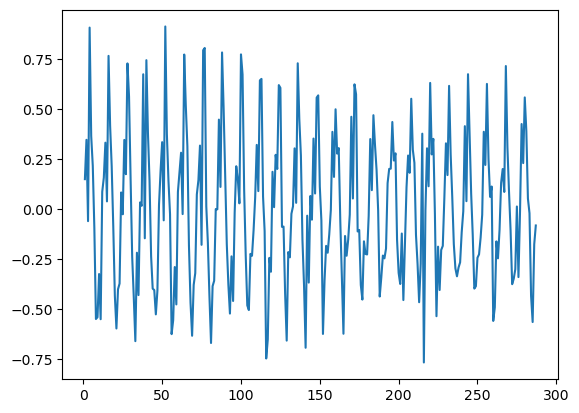

In [58]:
tslog = np.log(data['TouristNumber'])
logret= diff(tslog)
plt.plot(logret)
plt.show()

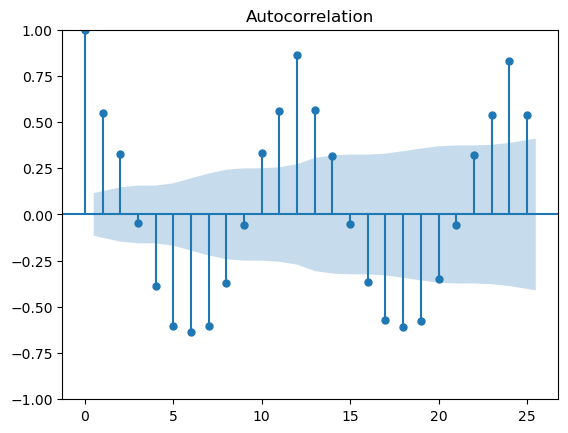

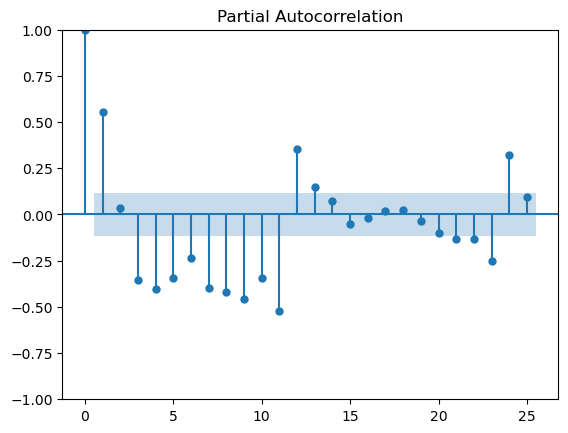

In [62]:
plot_acf(logret)
plot_pacf(logret)
plt.show()

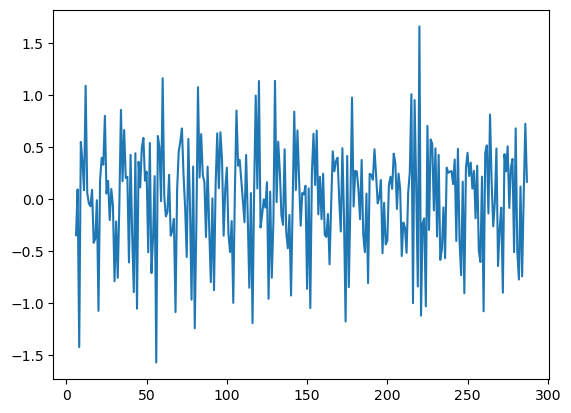

In [64]:
slogret= diff(diff(tslog),k_seasonal_diff=1,seasonal_periods=4)
plt.plot(slogret)
plt.show()

In [65]:
m = int(np.log(data.shape[0]))

acorr_ljungbox(slogret, lags=[m])

,lb_stat,lb_pvalue
5,86.249288,4.117881e-17


c:\Users\gusal\miniconda3\envs\Ambiente-Conda\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


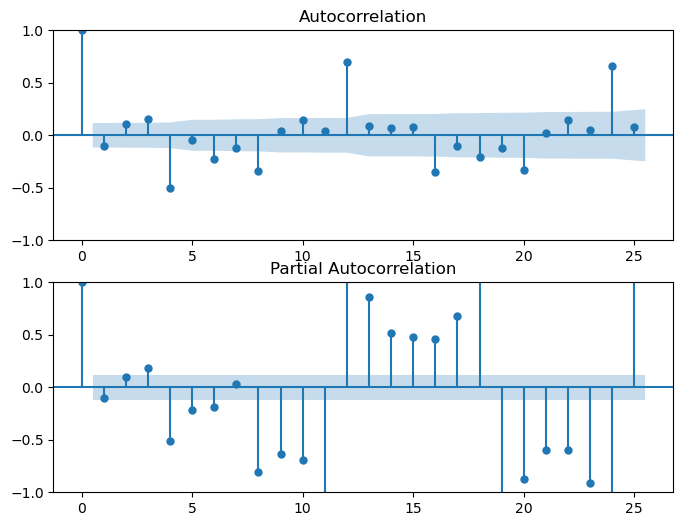

In [66]:
fig,ax = plt.subplots(2,1,figsize=(8,6))
plot_acf(slogret,ax=ax[0])
plot_pacf(slogret,ax=ax[1])
plt.show()

In [68]:
import statsmodels.api as sm
pp = []
qq = []
PP = []
QQ = []
aic = []
lb = []
sse = []
for p in range(0,2):
    for q in range(0,2):
        for P in range(0,2):
            for Q in range(0,2):
                model=sm.tsa.statespace.SARIMAX(np.log(data['TouristNumber']),order=(p, 1, q),seasonal_order=(P,1,Q,4))
                res = model.fit()
                pp.append(p)
                qq.append(q)
                PP.append(P)
                QQ.append(Q)
                aic.append(res.aic)
                lb.append(acorr_ljungbox(res.resid, lags=[m]))
                sse.append((res.resid**2).sum())

resdf = pd.DataFrame()
resdf['p']=pp
resdf['q']=qq
resdf['PP']=PP
resdf['QQ']=QQ
resdf['AIC']=aic
resdf['lb-p-value']=lb
resdf['sse']=sse

In [69]:
resdf

,p,q,PP,QQ,AIC,lb-p-value,sse
0,0,0,0,0,524.365902,lb_stat lb_pvalue 5 115.928148 2.2...,199.804726
1,0,0,0,1,249.025253,lb_stat lb_pvalue 5 49.864649 1.477...,135.308221
2,0,0,1,0,445.598343,lb_stat lb_pvalue 5 92.43109 2.07208...,173.980787
3,0,0,1,1,191.261930,lb_stat lb_pvalue 5 38.153556 3.514...,128.201798
4,0,1,0,0,386.635798,lb_stat lb_pvalue 5 38.894448 2.493...,159.022609
5,0,1,0,1,156.735373,lb_stat lb_pvalue 5 30.078747 0.000014,123.809547
6,0,1,1,0,328.189567,lb_stat lb_pvalue 5 38.100094 3.602...,146.856899
7,0,1,1,1,116.226455,lb_stat lb_pvalue 5 25.818465 0.000097,120.187866
8,1,0,0,0,379.250573,lb_stat lb_pvalue 5 44.231206 2.078...,157.168618
9,1,0,0,1,124.001113,lb_stat lb_pvalue 5 27.659737 0.000042,120.571000


El 11 es el chido

In [71]:
model=sm.tsa.statespace.SARIMAX(np.log(data['TouristNumber']),order=(1, 0, 1),seasonal_order=(1,1,0,4))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      TouristNumber   No. Observations:                  288
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 4)   Log Likelihood                -141.722
Date:                            Thu, 24 Oct 2024   AIC                            291.443
Time:                                    23:43:07   BIC                            306.039
Sample:                                         0   HQIC                           297.295
                                            - 288                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7038      0.077      9.179      0.000       0.554       0.854
ma.L1          0.8003      0.046     17.245      0.000       0.709       0.891
ar.S.L4       -0.4719      0.081     -5.861      0.000      -0.630      -0.314
sigma2         0.1568      0.014     10.929      0.000       0.129       0.185
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):                 2.30
Prob(Q):                              0.34   Prob(JB):                         0.32
Heteroskedasticity (H):               0.78   Skew:                             0.19
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

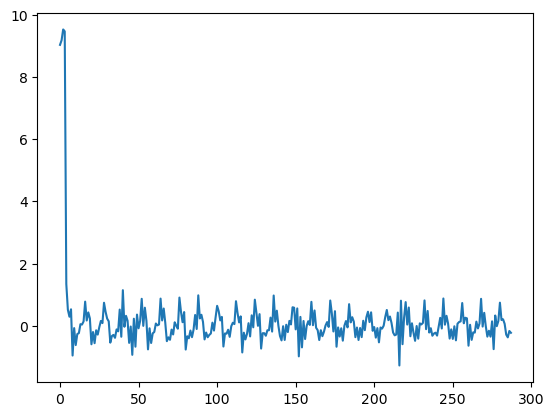

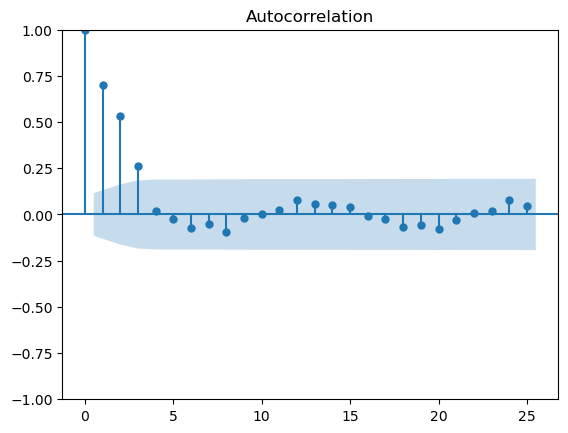

In [72]:
plt.plot(res.resid)
plot_acf(res.resid)
plt.show()

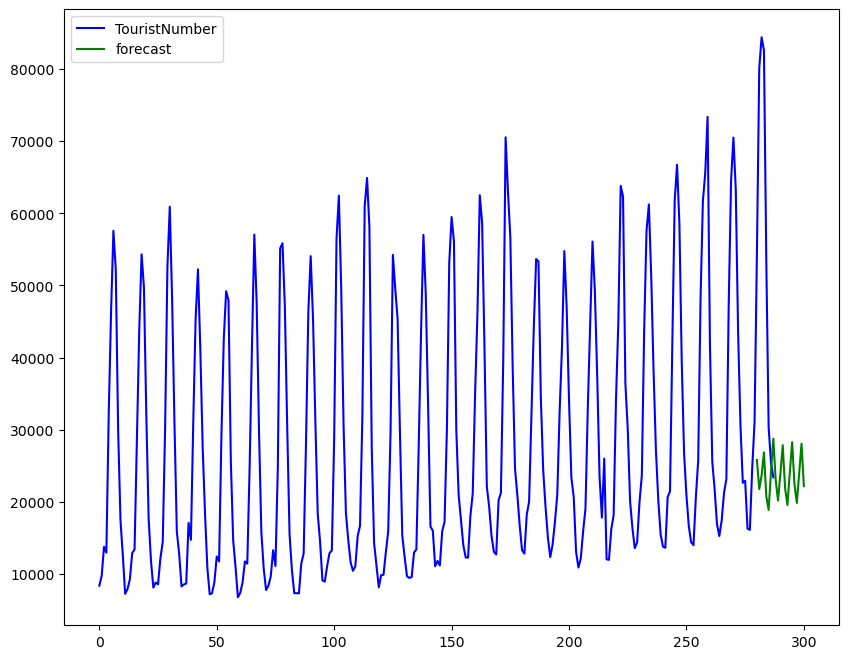

In [76]:
forecast=np.exp(res.predict(start=280,end=300,signal_only=True,dynamic=True))

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(data.index,data['TouristNumber'],label='TouristNumber',color='blue')
ax.plot(forecast,label='forecast',color='green')
plt.legend()
plt.show()

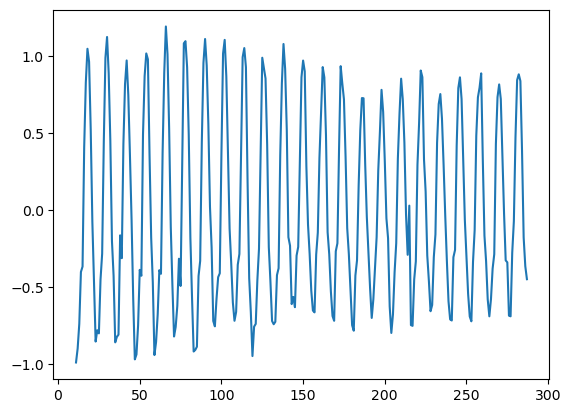

In [77]:
tslog2 = np.log(data['TouristNumber'])
rollavg = tslog2.rolling(12).mean()
tslogdiff = tslog2 - rollavg
tslogdiff.dropna(inplace = True)
plt.plot(tslogdiff)
plt.show()

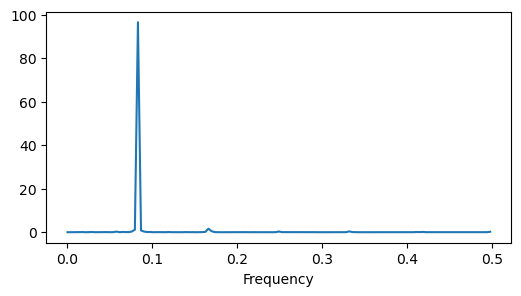

In [78]:
from scipy import signal
f, Pxx = signal.periodogram(tslogdiff)
fig, ax = plt.subplots(figsize=(6,3))
plt.plot(f, Pxx)
plt.xlabel('Frequency')
plt.show()


In [79]:
top_4_periods = {}

# get indices for 4 highest Pxx values
top4_freq_indices = np.flip(np.argsort(Pxx), 0)[0:4]


freqs = f[top4_freq_indices]

# use same indices to get powers as well
power = Pxx[top4_freq_indices]

# we are interested in period and it is calculated as 1/frequency
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_4_periods['period1'] = periods[0]
top_4_periods['freq1'] = freqs[0]
top_4_periods['power1'] = power[0]

top_4_periods['period2'] = periods[1]
top_4_periods['freq2'] = freqs[1]
top_4_periods['power2'] = power[1]

top_4_periods['period3'] = periods[2]
top_4_periods['freq3'] = freqs[2]
top_4_periods['power3'] = power[2]

top_4_periods['period4'] = periods[3]
top_4_periods['freq4'] = freqs[3]
top_4_periods['power4'] = power[3]


In [80]:
top_4_periods


{'period1': 12.043478260869565,
 'freq1': 0.08303249097472924,
 'power1': 96.56908333532222,
 'period2': 6.021739130434782,
 'freq2': 0.16606498194945848,
 'power2': 1.6217212459728858,
 'period3': 12.59090909090909,
 'freq3': 0.07942238267148015,
 'power3': 1.1630201806769755,
 'period4': 11.541666666666666,
 'freq4': 0.08664259927797835,
 'power4': 0.8182734772187514}

In [81]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    freqencies, spectrum = periodogram(ts)
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1/12, 1/6, 1/4, 1/3, 1/2])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "3 months",
            "Bimonthly (6)",
        ],
        rotation=90,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


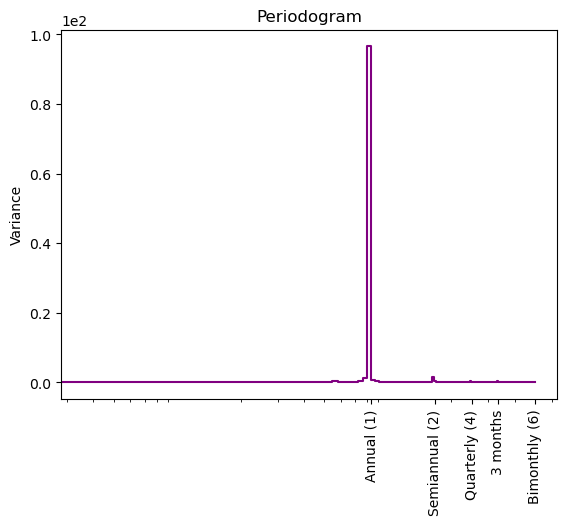

In [82]:
plot_periodogram(tslogdiff)
plt.show()

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(data['TouristNumber'], model='multiplicable',period=12)

<AxesSubplot:>

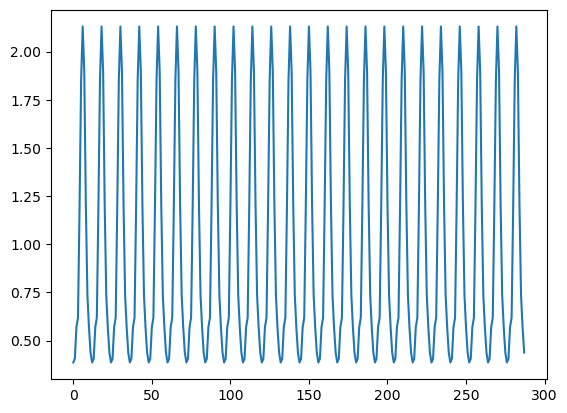

In [84]:
result.seasonal.plot()

<AxesSubplot:>

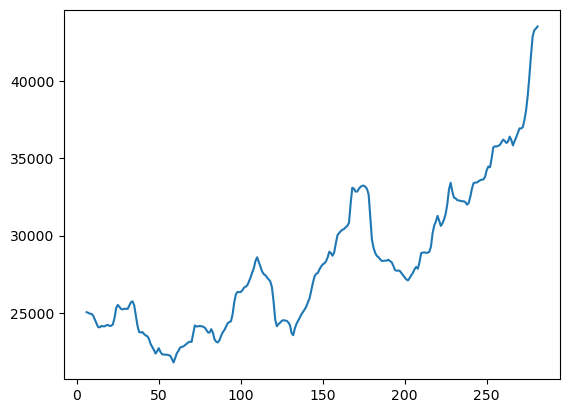

In [85]:
result.trend.plot()


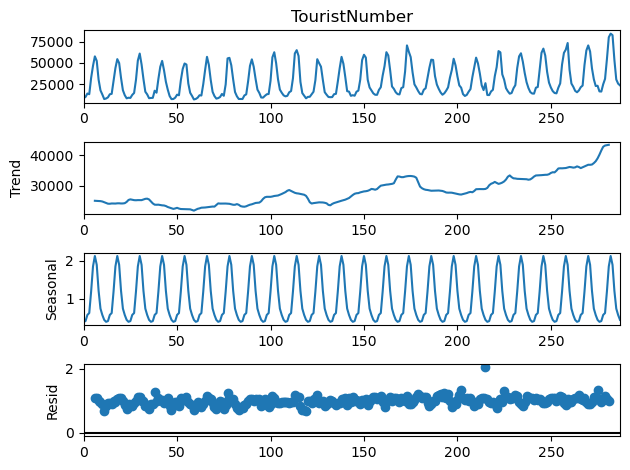

In [86]:
result.plot()
plt.show()

Hasta aqui mi participación :D